In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision import datasets, transforms 

In [3]:
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')

print(DEVICE, '\ttorch : {}'.format(torch.__version__))

cuda 	torch : 1.12.0


In [4]:
BATCH_SIZE = 128 
EPOCHS = 100 

In [5]:
train_dataset = datasets.FashionMNIST(root='../../data/FashionMNIST',
                                      download=True,
                                      train = True,
                                      transform= transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           shuffle = True, 
                                           batch_size = BATCH_SIZE)

test_dataset = datasets.FashionMNIST(root='../../data/FashionMNIST',
                                      download=True,
                                      train = False,
                                      transform= transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           shuffle = False, 
                                           batch_size = BATCH_SIZE)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../../data/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../../data/FashionMNIST\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../../data/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../../data/FashionMNIST\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../../data/FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../../data/FashionMNIST\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../../data/FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../../data/FashionMNIST\FashionMNIST\raw



In [6]:
for (X_train, y_train) in train_loader :
    print(X_train.size(), y_train.size())
    print(X_train.type(), y_train.type())
    break

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.FloatTensor torch.LongTensor


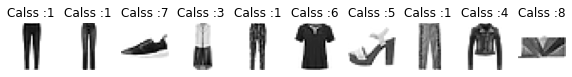

In [10]:
pltsize = 1
plt.figure(figsize=(pltsize * 10, pltsize))

for i in range(10) :
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = 'gray_r')
    plt.title('Calss :' + str(y_train[i].item()))
plt.show()

In [28]:
class AE(nn.Module) :
    def __init__(self) :
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32)
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28)
        )

    def forward(self, x ) :
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [58]:
del model

In [59]:
model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.MSELoss()
print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [60]:
def train(model, train_loader, optimizer, log_intervals = 100) :
    model.train()
    for batch_idx, (image, _) in enumerate(train_loader) :
        image = image.view(-1, 28 * 28).to(DEVICE)
        target = image.view(-1, 28 * 28).to(DEVICE)
        encoded, decoded = model(image)
        optimizer.zero_grad()
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_intervals == 0 :
            print('Train_Epoch : {}, [{} / {}]({:.0f}%)\tTrain_loss : {:.6f}'.format(
                Epoch, batch_idx * len(image), len(train_loader.dataset),
                batch_idx * 100 / len(train_loader), loss.item()
            ))

In [61]:
def evaluate(model, test_loader) :
    model.eval()
    real_image = []
    gen_image = []
    test_loss = 0
    with torch.no_grad() :
        for image, _ in test_loader :
            image = image.view(-1, 28 * 28).to(DEVICE)
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, decoded = model(image)
            test_loss = criterion(decoded, image).item()

        test_loss = test_loss / len(test_loader.dataset)
        real_image.append(image.to('cpu'))
        gen_image.append(decoded.to('cpu'))

    return test_loss, real_image, gen_image

Train_Epoch : 1, [0 / 60000](0%)	Train_loss : 0.219848
Train_Epoch : 1, [12800 / 60000](21%)	Train_loss : 0.038636
Train_Epoch : 1, [25600 / 60000](43%)	Train_loss : 0.037509
Train_Epoch : 1, [38400 / 60000](64%)	Train_loss : 0.035032
Train_Epoch : 1, [51200 / 60000](85%)	Train_loss : 0.032912
EPOCH : 1	Test_loss : 0.000005


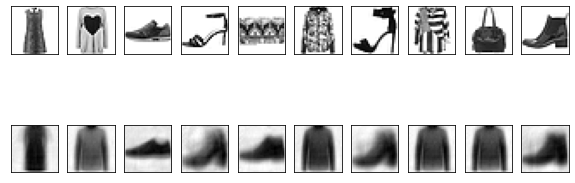

Train_Epoch : 2, [0 / 60000](0%)	Train_loss : 0.036923
Train_Epoch : 2, [12800 / 60000](21%)	Train_loss : 0.031431
Train_Epoch : 2, [25600 / 60000](43%)	Train_loss : 0.037240
Train_Epoch : 2, [38400 / 60000](64%)	Train_loss : 0.034080
Train_Epoch : 2, [51200 / 60000](85%)	Train_loss : 0.032877
EPOCH : 2	Test_loss : 0.000005


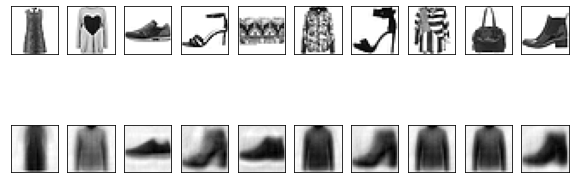

Train_Epoch : 3, [0 / 60000](0%)	Train_loss : 0.033454
Train_Epoch : 3, [12800 / 60000](21%)	Train_loss : 0.035188
Train_Epoch : 3, [25600 / 60000](43%)	Train_loss : 0.035876
Train_Epoch : 3, [38400 / 60000](64%)	Train_loss : 0.035447
Train_Epoch : 3, [51200 / 60000](85%)	Train_loss : 0.033437
EPOCH : 3	Test_loss : 0.000005


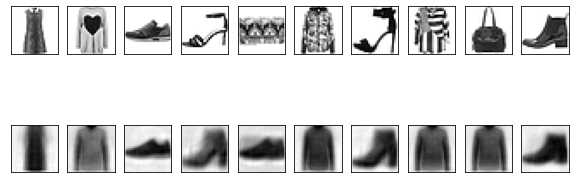

Train_Epoch : 4, [0 / 60000](0%)	Train_loss : 0.034308
Train_Epoch : 4, [12800 / 60000](21%)	Train_loss : 0.030275
Train_Epoch : 4, [25600 / 60000](43%)	Train_loss : 0.032276
Train_Epoch : 4, [38400 / 60000](64%)	Train_loss : 0.031557
Train_Epoch : 4, [51200 / 60000](85%)	Train_loss : 0.030794
EPOCH : 4	Test_loss : 0.000004


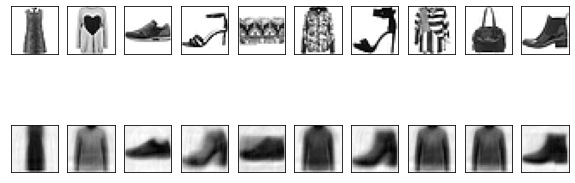

Train_Epoch : 5, [0 / 60000](0%)	Train_loss : 0.033383
Train_Epoch : 5, [12800 / 60000](21%)	Train_loss : 0.031594
Train_Epoch : 5, [25600 / 60000](43%)	Train_loss : 0.032473
Train_Epoch : 5, [38400 / 60000](64%)	Train_loss : 0.034577
Train_Epoch : 5, [51200 / 60000](85%)	Train_loss : 0.031918
EPOCH : 5	Test_loss : 0.000004


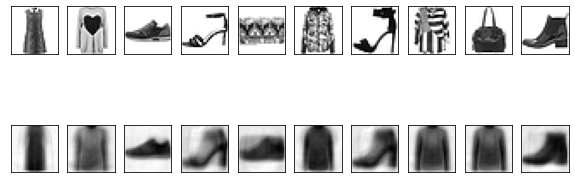

Train_Epoch : 6, [0 / 60000](0%)	Train_loss : 0.032201
Train_Epoch : 6, [12800 / 60000](21%)	Train_loss : 0.031154
Train_Epoch : 6, [25600 / 60000](43%)	Train_loss : 0.035891
Train_Epoch : 6, [38400 / 60000](64%)	Train_loss : 0.036869
Train_Epoch : 6, [51200 / 60000](85%)	Train_loss : 0.032742
EPOCH : 6	Test_loss : 0.000004


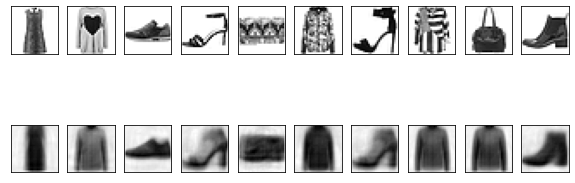

Train_Epoch : 7, [0 / 60000](0%)	Train_loss : 0.029615
Train_Epoch : 7, [12800 / 60000](21%)	Train_loss : 0.031421
Train_Epoch : 7, [25600 / 60000](43%)	Train_loss : 0.032097
Train_Epoch : 7, [38400 / 60000](64%)	Train_loss : 0.033261
Train_Epoch : 7, [51200 / 60000](85%)	Train_loss : 0.033121
EPOCH : 7	Test_loss : 0.000004


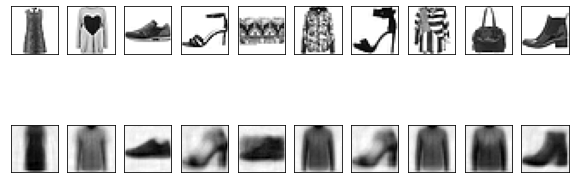

Train_Epoch : 8, [0 / 60000](0%)	Train_loss : 0.031195
Train_Epoch : 8, [12800 / 60000](21%)	Train_loss : 0.033026
Train_Epoch : 8, [25600 / 60000](43%)	Train_loss : 0.030048
Train_Epoch : 8, [38400 / 60000](64%)	Train_loss : 0.030295
Train_Epoch : 8, [51200 / 60000](85%)	Train_loss : 0.029299
EPOCH : 8	Test_loss : 0.000004


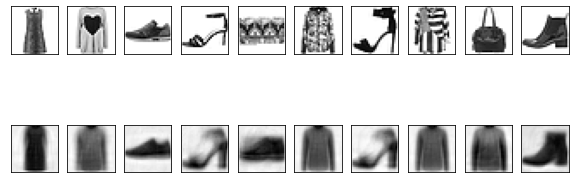

Train_Epoch : 9, [0 / 60000](0%)	Train_loss : 0.028501
Train_Epoch : 9, [12800 / 60000](21%)	Train_loss : 0.027375
Train_Epoch : 9, [25600 / 60000](43%)	Train_loss : 0.031966
Train_Epoch : 9, [38400 / 60000](64%)	Train_loss : 0.031901
Train_Epoch : 9, [51200 / 60000](85%)	Train_loss : 0.027814
EPOCH : 9	Test_loss : 0.000004


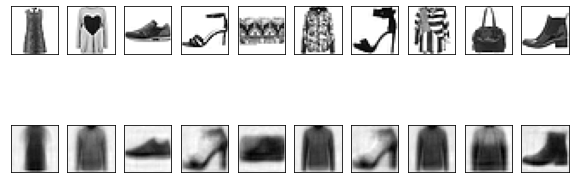

Train_Epoch : 10, [0 / 60000](0%)	Train_loss : 0.028865
Train_Epoch : 10, [12800 / 60000](21%)	Train_loss : 0.028458
Train_Epoch : 10, [25600 / 60000](43%)	Train_loss : 0.030357
Train_Epoch : 10, [38400 / 60000](64%)	Train_loss : 0.030382
Train_Epoch : 10, [51200 / 60000](85%)	Train_loss : 0.033109
EPOCH : 10	Test_loss : 0.000004


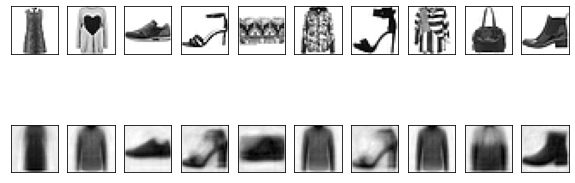

Train_Epoch : 11, [0 / 60000](0%)	Train_loss : 0.028641
Train_Epoch : 11, [12800 / 60000](21%)	Train_loss : 0.026230
Train_Epoch : 11, [25600 / 60000](43%)	Train_loss : 0.029014
Train_Epoch : 11, [38400 / 60000](64%)	Train_loss : 0.027611
Train_Epoch : 11, [51200 / 60000](85%)	Train_loss : 0.027834
EPOCH : 11	Test_loss : 0.000003


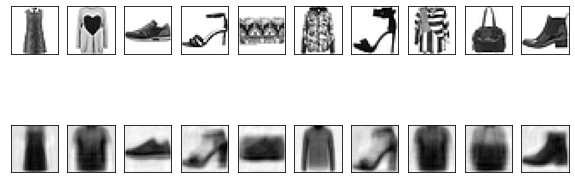

Train_Epoch : 12, [0 / 60000](0%)	Train_loss : 0.026403
Train_Epoch : 12, [12800 / 60000](21%)	Train_loss : 0.028087
Train_Epoch : 12, [25600 / 60000](43%)	Train_loss : 0.023638
Train_Epoch : 12, [38400 / 60000](64%)	Train_loss : 0.026381
Train_Epoch : 12, [51200 / 60000](85%)	Train_loss : 0.029445
EPOCH : 12	Test_loss : 0.000003


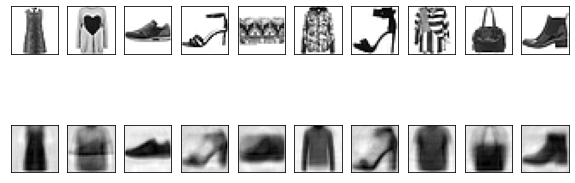

Train_Epoch : 13, [0 / 60000](0%)	Train_loss : 0.025729
Train_Epoch : 13, [12800 / 60000](21%)	Train_loss : 0.026621
Train_Epoch : 13, [25600 / 60000](43%)	Train_loss : 0.025128
Train_Epoch : 13, [38400 / 60000](64%)	Train_loss : 0.026255
Train_Epoch : 13, [51200 / 60000](85%)	Train_loss : 0.027421
EPOCH : 13	Test_loss : 0.000003


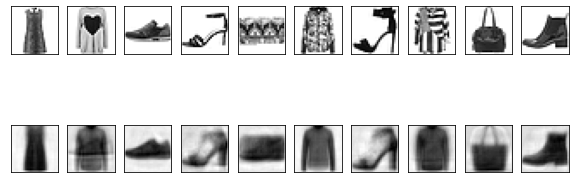

Train_Epoch : 14, [0 / 60000](0%)	Train_loss : 0.026711
Train_Epoch : 14, [12800 / 60000](21%)	Train_loss : 0.024040
Train_Epoch : 14, [25600 / 60000](43%)	Train_loss : 0.026657
Train_Epoch : 14, [38400 / 60000](64%)	Train_loss : 0.024453
Train_Epoch : 14, [51200 / 60000](85%)	Train_loss : 0.026079
EPOCH : 14	Test_loss : 0.000003


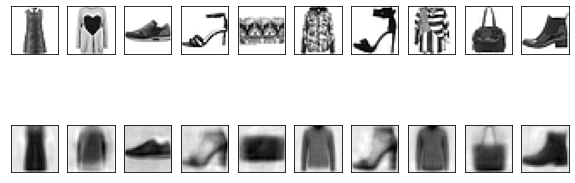

Train_Epoch : 15, [0 / 60000](0%)	Train_loss : 0.024850
Train_Epoch : 15, [12800 / 60000](21%)	Train_loss : 0.024024
Train_Epoch : 15, [25600 / 60000](43%)	Train_loss : 0.024034
Train_Epoch : 15, [38400 / 60000](64%)	Train_loss : 0.025485
Train_Epoch : 15, [51200 / 60000](85%)	Train_loss : 0.022492
EPOCH : 15	Test_loss : 0.000003


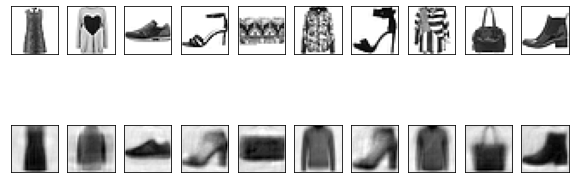

Train_Epoch : 16, [0 / 60000](0%)	Train_loss : 0.024571
Train_Epoch : 16, [12800 / 60000](21%)	Train_loss : 0.024683
Train_Epoch : 16, [25600 / 60000](43%)	Train_loss : 0.024410
Train_Epoch : 16, [38400 / 60000](64%)	Train_loss : 0.022179
Train_Epoch : 16, [51200 / 60000](85%)	Train_loss : 0.024126
EPOCH : 16	Test_loss : 0.000003


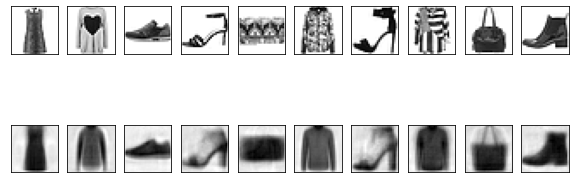

Train_Epoch : 17, [0 / 60000](0%)	Train_loss : 0.023670
Train_Epoch : 17, [12800 / 60000](21%)	Train_loss : 0.026758
Train_Epoch : 17, [25600 / 60000](43%)	Train_loss : 0.024646
Train_Epoch : 17, [38400 / 60000](64%)	Train_loss : 0.024098
Train_Epoch : 17, [51200 / 60000](85%)	Train_loss : 0.024456
EPOCH : 17	Test_loss : 0.000003


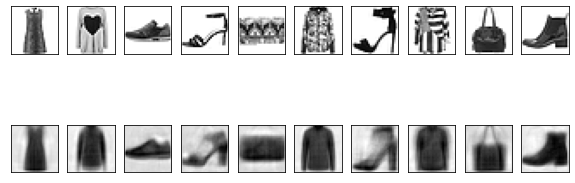

Train_Epoch : 18, [0 / 60000](0%)	Train_loss : 0.022510
Train_Epoch : 18, [12800 / 60000](21%)	Train_loss : 0.024507
Train_Epoch : 18, [25600 / 60000](43%)	Train_loss : 0.023172
Train_Epoch : 18, [38400 / 60000](64%)	Train_loss : 0.025154
Train_Epoch : 18, [51200 / 60000](85%)	Train_loss : 0.023577
EPOCH : 18	Test_loss : 0.000003


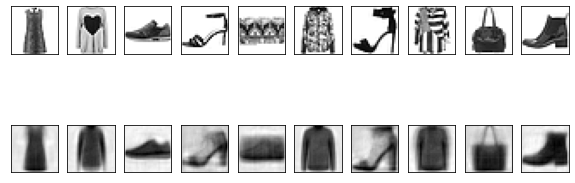

Train_Epoch : 19, [0 / 60000](0%)	Train_loss : 0.023017
Train_Epoch : 19, [12800 / 60000](21%)	Train_loss : 0.021407
Train_Epoch : 19, [25600 / 60000](43%)	Train_loss : 0.022989
Train_Epoch : 19, [38400 / 60000](64%)	Train_loss : 0.022319
Train_Epoch : 19, [51200 / 60000](85%)	Train_loss : 0.020903
EPOCH : 19	Test_loss : 0.000003


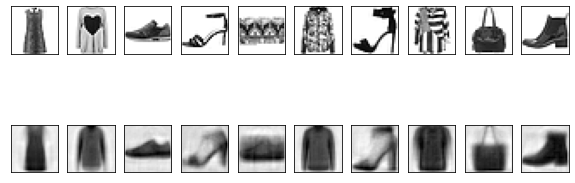

Train_Epoch : 20, [0 / 60000](0%)	Train_loss : 0.024712
Train_Epoch : 20, [12800 / 60000](21%)	Train_loss : 0.024742
Train_Epoch : 20, [25600 / 60000](43%)	Train_loss : 0.024167
Train_Epoch : 20, [38400 / 60000](64%)	Train_loss : 0.023532
Train_Epoch : 20, [51200 / 60000](85%)	Train_loss : 0.023283
EPOCH : 20	Test_loss : 0.000003


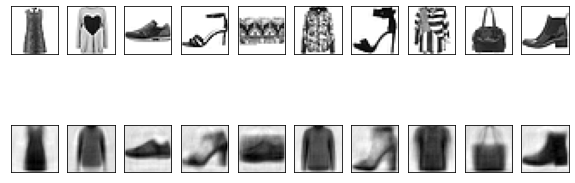

Train_Epoch : 21, [0 / 60000](0%)	Train_loss : 0.023576
Train_Epoch : 21, [12800 / 60000](21%)	Train_loss : 0.023901
Train_Epoch : 21, [25600 / 60000](43%)	Train_loss : 0.023189
Train_Epoch : 21, [38400 / 60000](64%)	Train_loss : 0.023718
Train_Epoch : 21, [51200 / 60000](85%)	Train_loss : 0.023902
EPOCH : 21	Test_loss : 0.000003


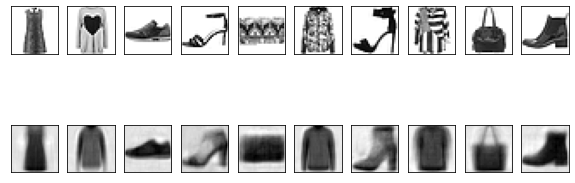

Train_Epoch : 22, [0 / 60000](0%)	Train_loss : 0.021582
Train_Epoch : 22, [12800 / 60000](21%)	Train_loss : 0.026361
Train_Epoch : 22, [25600 / 60000](43%)	Train_loss : 0.023327
Train_Epoch : 22, [38400 / 60000](64%)	Train_loss : 0.025137
Train_Epoch : 22, [51200 / 60000](85%)	Train_loss : 0.021857
EPOCH : 22	Test_loss : 0.000003


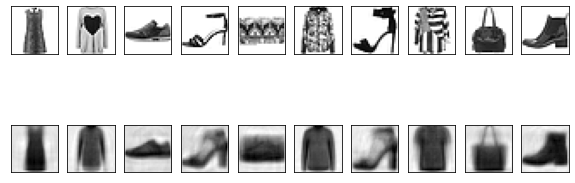

Train_Epoch : 23, [0 / 60000](0%)	Train_loss : 0.023019
Train_Epoch : 23, [12800 / 60000](21%)	Train_loss : 0.022628
Train_Epoch : 23, [25600 / 60000](43%)	Train_loss : 0.022254
Train_Epoch : 23, [38400 / 60000](64%)	Train_loss : 0.023025
Train_Epoch : 23, [51200 / 60000](85%)	Train_loss : 0.025732
EPOCH : 23	Test_loss : 0.000003


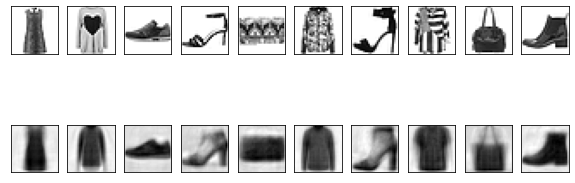

Train_Epoch : 24, [0 / 60000](0%)	Train_loss : 0.023650
Train_Epoch : 24, [12800 / 60000](21%)	Train_loss : 0.025101
Train_Epoch : 24, [25600 / 60000](43%)	Train_loss : 0.022684
Train_Epoch : 24, [38400 / 60000](64%)	Train_loss : 0.023590
Train_Epoch : 24, [51200 / 60000](85%)	Train_loss : 0.023545
EPOCH : 24	Test_loss : 0.000003


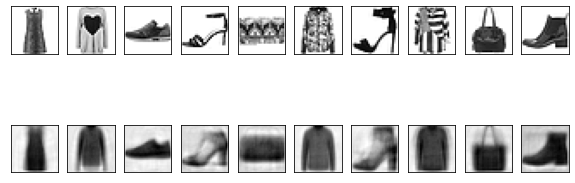

Train_Epoch : 25, [0 / 60000](0%)	Train_loss : 0.023093
Train_Epoch : 25, [12800 / 60000](21%)	Train_loss : 0.025216
Train_Epoch : 25, [25600 / 60000](43%)	Train_loss : 0.023545
Train_Epoch : 25, [38400 / 60000](64%)	Train_loss : 0.023288
Train_Epoch : 25, [51200 / 60000](85%)	Train_loss : 0.022705
EPOCH : 25	Test_loss : 0.000003


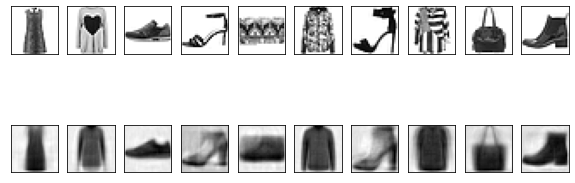

Train_Epoch : 26, [0 / 60000](0%)	Train_loss : 0.022077
Train_Epoch : 26, [12800 / 60000](21%)	Train_loss : 0.022558
Train_Epoch : 26, [25600 / 60000](43%)	Train_loss : 0.025037
Train_Epoch : 26, [38400 / 60000](64%)	Train_loss : 0.022696
Train_Epoch : 26, [51200 / 60000](85%)	Train_loss : 0.023146
EPOCH : 26	Test_loss : 0.000003


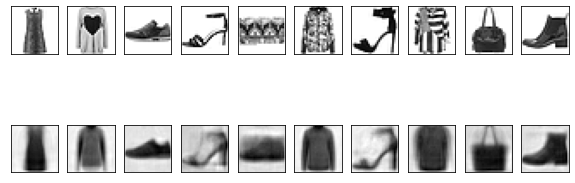

Train_Epoch : 27, [0 / 60000](0%)	Train_loss : 0.022689
Train_Epoch : 27, [12800 / 60000](21%)	Train_loss : 0.026349
Train_Epoch : 27, [25600 / 60000](43%)	Train_loss : 0.023199
Train_Epoch : 27, [38400 / 60000](64%)	Train_loss : 0.021977
Train_Epoch : 27, [51200 / 60000](85%)	Train_loss : 0.023341
EPOCH : 27	Test_loss : 0.000003


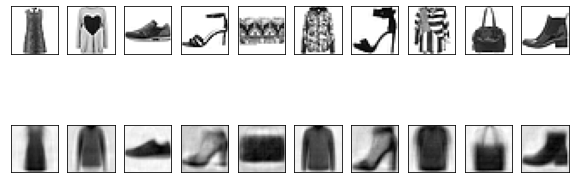

Train_Epoch : 28, [0 / 60000](0%)	Train_loss : 0.022820
Train_Epoch : 28, [12800 / 60000](21%)	Train_loss : 0.027495
Train_Epoch : 28, [25600 / 60000](43%)	Train_loss : 0.022800
Train_Epoch : 28, [38400 / 60000](64%)	Train_loss : 0.022582
Train_Epoch : 28, [51200 / 60000](85%)	Train_loss : 0.022203
EPOCH : 28	Test_loss : 0.000003


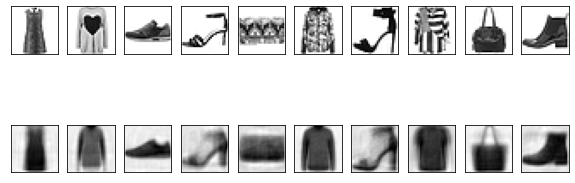

Train_Epoch : 29, [0 / 60000](0%)	Train_loss : 0.022380
Train_Epoch : 29, [12800 / 60000](21%)	Train_loss : 0.022655
Train_Epoch : 29, [25600 / 60000](43%)	Train_loss : 0.023041
Train_Epoch : 29, [38400 / 60000](64%)	Train_loss : 0.022381
Train_Epoch : 29, [51200 / 60000](85%)	Train_loss : 0.023129
EPOCH : 29	Test_loss : 0.000003


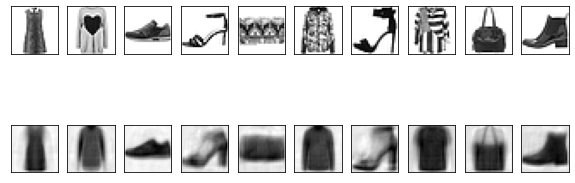

Train_Epoch : 30, [0 / 60000](0%)	Train_loss : 0.024966
Train_Epoch : 30, [12800 / 60000](21%)	Train_loss : 0.024913
Train_Epoch : 30, [25600 / 60000](43%)	Train_loss : 0.022965
Train_Epoch : 30, [38400 / 60000](64%)	Train_loss : 0.023070
Train_Epoch : 30, [51200 / 60000](85%)	Train_loss : 0.023094
EPOCH : 30	Test_loss : 0.000003


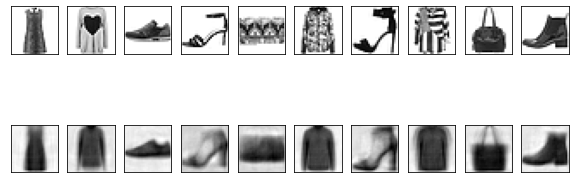

Train_Epoch : 31, [0 / 60000](0%)	Train_loss : 0.023014
Train_Epoch : 31, [12800 / 60000](21%)	Train_loss : 0.022241
Train_Epoch : 31, [25600 / 60000](43%)	Train_loss : 0.021730
Train_Epoch : 31, [38400 / 60000](64%)	Train_loss : 0.022188
Train_Epoch : 31, [51200 / 60000](85%)	Train_loss : 0.023858
EPOCH : 31	Test_loss : 0.000003


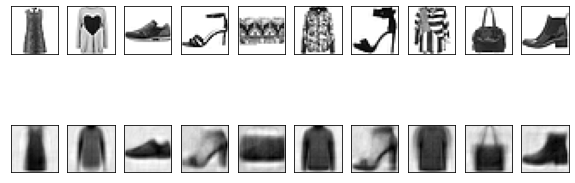

Train_Epoch : 32, [0 / 60000](0%)	Train_loss : 0.023061
Train_Epoch : 32, [12800 / 60000](21%)	Train_loss : 0.020145
Train_Epoch : 32, [25600 / 60000](43%)	Train_loss : 0.023125
Train_Epoch : 32, [38400 / 60000](64%)	Train_loss : 0.025423
Train_Epoch : 32, [51200 / 60000](85%)	Train_loss : 0.024896
EPOCH : 32	Test_loss : 0.000003


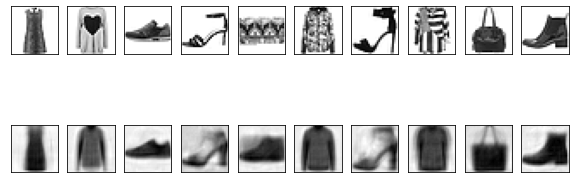

Train_Epoch : 33, [0 / 60000](0%)	Train_loss : 0.024269
Train_Epoch : 33, [12800 / 60000](21%)	Train_loss : 0.023936
Train_Epoch : 33, [25600 / 60000](43%)	Train_loss : 0.024345
Train_Epoch : 33, [38400 / 60000](64%)	Train_loss : 0.021837
Train_Epoch : 33, [51200 / 60000](85%)	Train_loss : 0.023766
EPOCH : 33	Test_loss : 0.000003


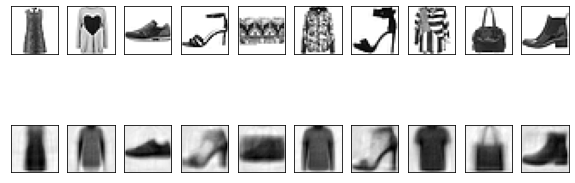

Train_Epoch : 34, [0 / 60000](0%)	Train_loss : 0.023815
Train_Epoch : 34, [12800 / 60000](21%)	Train_loss : 0.020838
Train_Epoch : 34, [25600 / 60000](43%)	Train_loss : 0.026530
Train_Epoch : 34, [38400 / 60000](64%)	Train_loss : 0.022574
Train_Epoch : 34, [51200 / 60000](85%)	Train_loss : 0.023488
EPOCH : 34	Test_loss : 0.000003


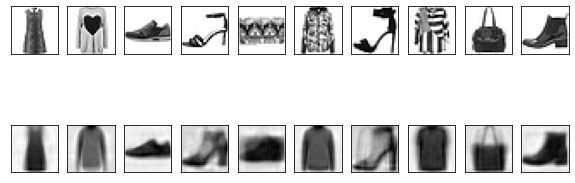

Train_Epoch : 35, [0 / 60000](0%)	Train_loss : 0.024445
Train_Epoch : 35, [12800 / 60000](21%)	Train_loss : 0.023292
Train_Epoch : 35, [25600 / 60000](43%)	Train_loss : 0.023108
Train_Epoch : 35, [38400 / 60000](64%)	Train_loss : 0.022520
Train_Epoch : 35, [51200 / 60000](85%)	Train_loss : 0.023836
EPOCH : 35	Test_loss : 0.000003


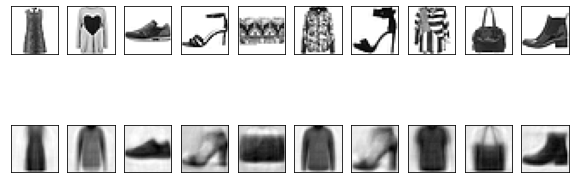

Train_Epoch : 36, [0 / 60000](0%)	Train_loss : 0.024178
Train_Epoch : 36, [12800 / 60000](21%)	Train_loss : 0.024653
Train_Epoch : 36, [25600 / 60000](43%)	Train_loss : 0.024251
Train_Epoch : 36, [38400 / 60000](64%)	Train_loss : 0.022901
Train_Epoch : 36, [51200 / 60000](85%)	Train_loss : 0.023363
EPOCH : 36	Test_loss : 0.000003


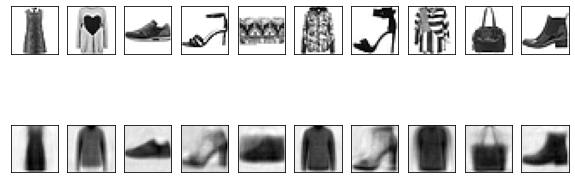

Train_Epoch : 37, [0 / 60000](0%)	Train_loss : 0.022793
Train_Epoch : 37, [12800 / 60000](21%)	Train_loss : 0.022539
Train_Epoch : 37, [25600 / 60000](43%)	Train_loss : 0.023140
Train_Epoch : 37, [38400 / 60000](64%)	Train_loss : 0.024561
Train_Epoch : 37, [51200 / 60000](85%)	Train_loss : 0.022563
EPOCH : 37	Test_loss : 0.000003


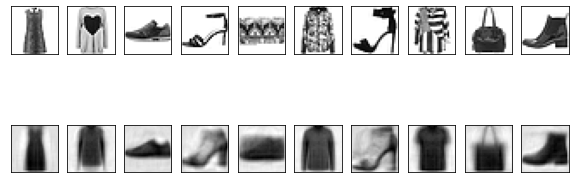

In [62]:
import sys
best_loss = sys.maxsize
es = 0 

for Epoch in range(1, EPOCHS + 1) :
    train(model, train_loader, optimizer)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print('EPOCH : {}\tTest_loss : {:6f}'.format(
        Epoch, test_loss
    ))
    f, a = plt.subplots(2, 10, figsize = (10, 4))
    for i in range(10) :
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap = 'gray_r')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())

    for i in range(10) :
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap = 'gray_r')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()

    if test_loss < best_loss :
        best_loss = test_loss
        best_model = model
        es = 0
    else : 
        es += 1

    if es >= 10 :
        break